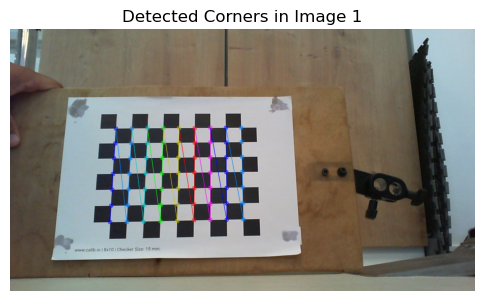

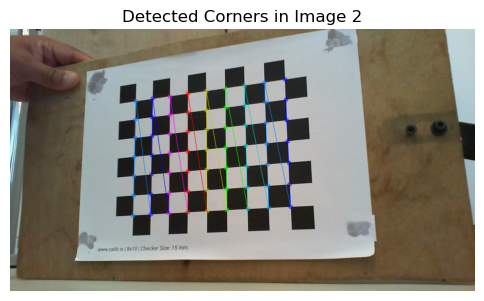

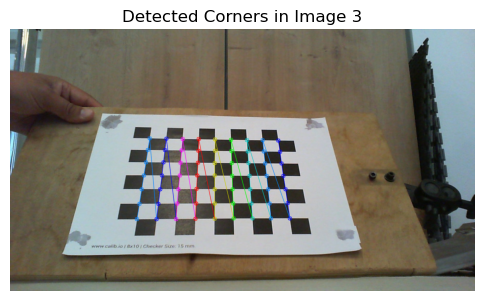

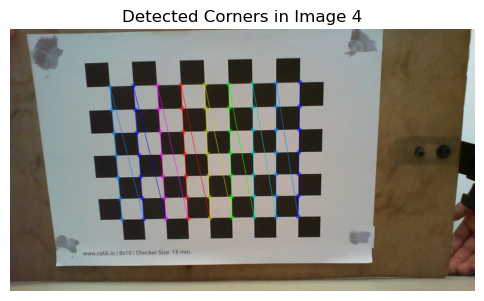

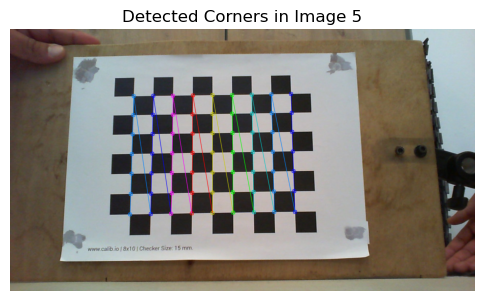

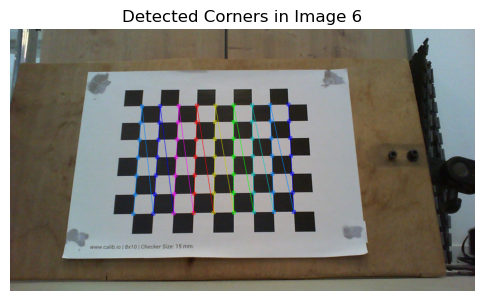

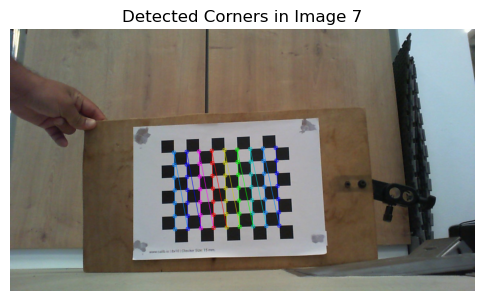

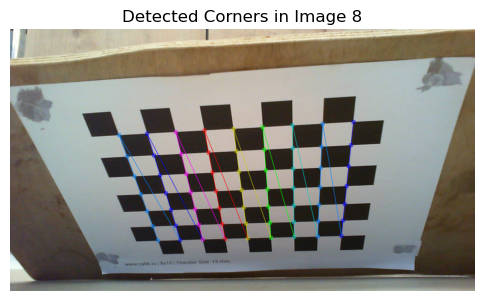

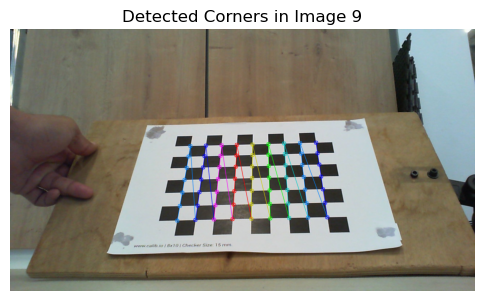

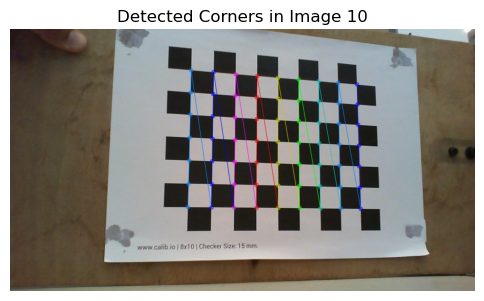

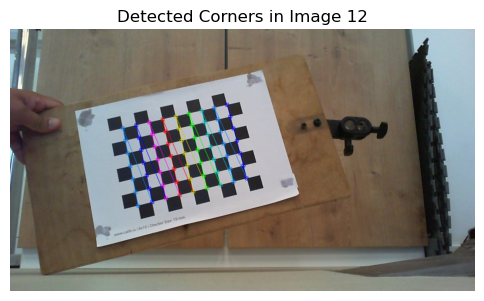

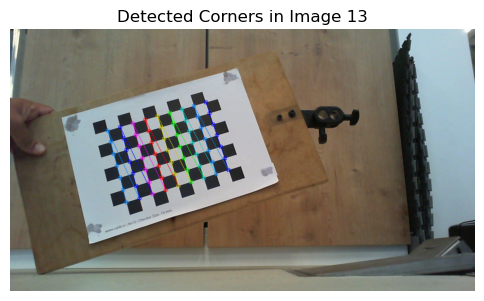

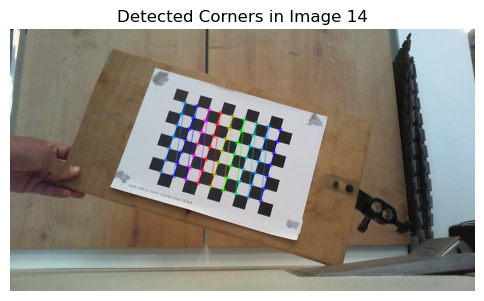

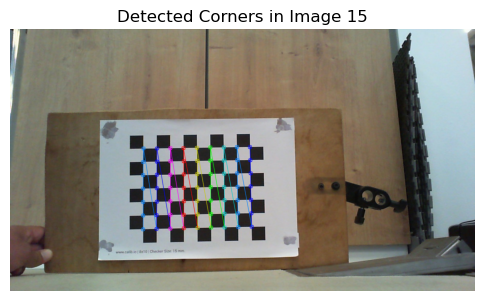

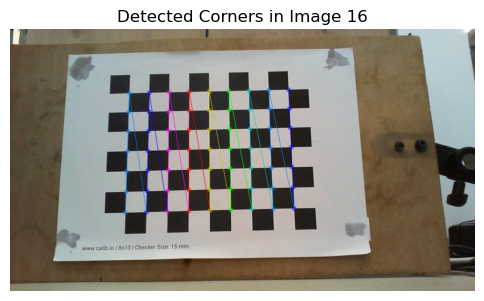

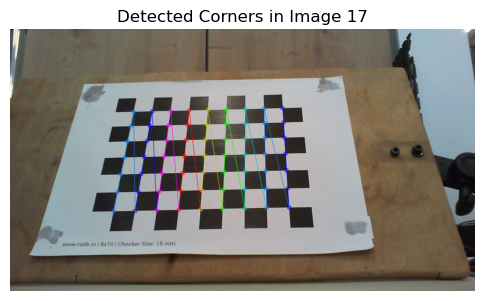

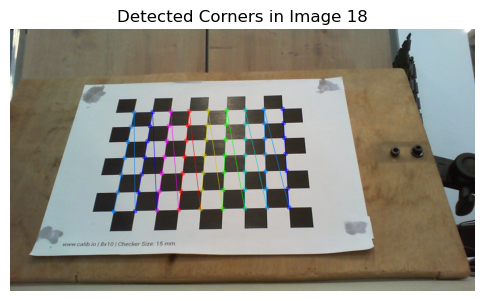

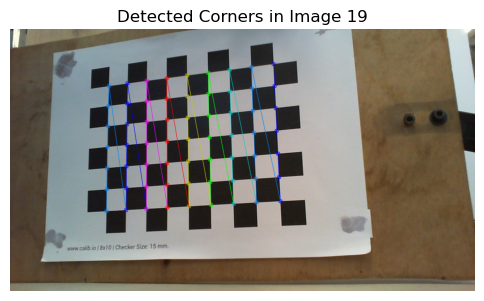

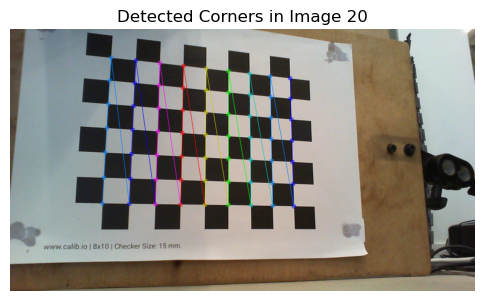

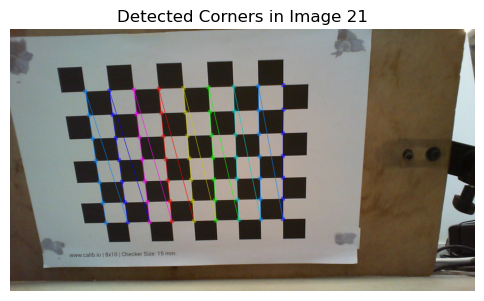

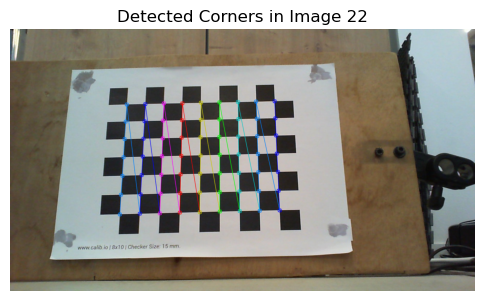

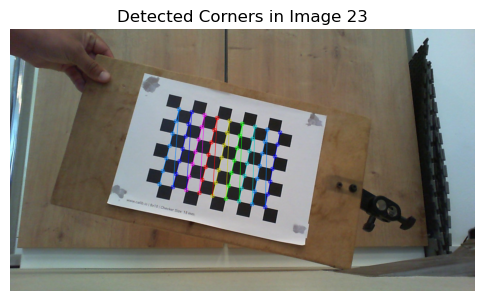

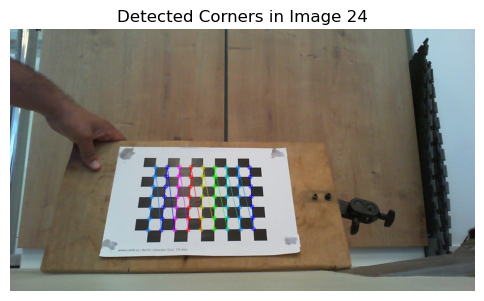

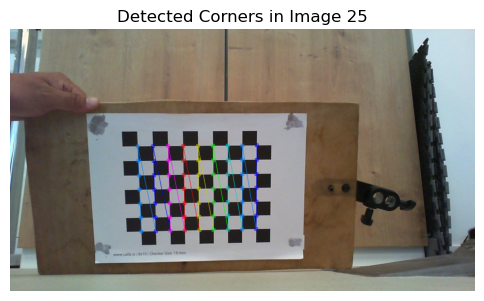

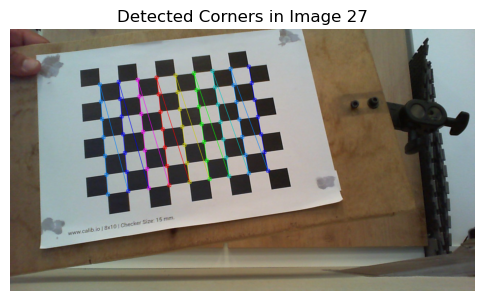

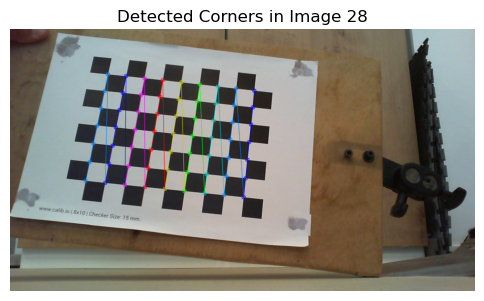


==== Camera Calibration Results ====
Intrinsic Camera Matrix:
 [[1.13364493e+03 0.00000000e+00 6.60786482e+02]
 [0.00000000e+00 1.12446461e+03 3.77012233e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [ 0.13847323 -0.92435038  0.00498605  0.00659831  1.34419323]

Average Reprojection Error: 0.027829045601472476

Calibration results saved to: c:\Users\hassa\OneDrive\Desktop\computer vision\yohan_project\stereo_camera_system\calibration_report.txt


In [8]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Define the chessboard configuration
pattern_size = (7, 9)  # Number of internal corners in the checkerboard (width, height)
square_length = 15.0  # Size of a square in chosen units (e.g., mm, cm)

# Generate 3D world coordinates for the checkerboard pattern
world_points = np.zeros((pattern_size[0] * pattern_size[1], 3), dtype=np.float32)
world_points[:, :2] = np.indices((pattern_size[0], pattern_size[1])).T.reshape(-1, 2) * square_length

# Lists to store object points (3D) and image points (2D)
object_points = []  # Real-world coordinates
image_points = []  # Corresponding image coordinates

# Load calibration images
#image_files = glob.glob(r"C:\Users\lenovo\Downloads\ima\ima\*.jpg")[:28]
image_files = glob.glob(os.path.join("ima", "*.jpg"))[:28]


# Check if images were found
if not image_files:
    raise FileNotFoundError("No calibration images found in the specified directory!")

# Process each calibration image
for idx, file in enumerate(image_files):
    image = cv2.imread(file)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect chessboard corners
    found, corners = cv2.findChessboardCorners(grayscale, pattern_size, None)
    
    if found:
        object_points.append(world_points)
        image_points.append(corners)
        
        # Refine corner detection for accuracy
        corners_subpix = cv2.cornerSubPix(grayscale, corners, (11, 11), (-1, -1), 
                                          criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        # Convert image to RGB and visualize detected corners
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.drawChessboardCorners(image_rgb, pattern_size, corners_subpix, found)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.title(f"Detected Corners in Image {idx+1}")
        plt.axis("off")
        plt.show()

# Close OpenCV windows
cv2.destroyAllWindows()

# Perform camera calibration
success, camera_matrix, distortion_coeffs, rotation_vecs, translation_vecs = cv2.calibrateCamera(
    object_points, image_points, grayscale.shape[::-1], None, None
)

if not success:
    raise RuntimeError("Camera calibration failed!")

# Compute reprojection error
total_error = 0
for i in range(len(object_points)):
    projected_points, _ = cv2.projectPoints(object_points[i], rotation_vecs[i], translation_vecs[i], camera_matrix, distortion_coeffs)
    error = cv2.norm(image_points[i], projected_points, cv2.NORM_L2) / len(projected_points)
    total_error += error

average_error = total_error / len(object_points)

# Save results to a report file
report_path = os.path.join(os.getcwd(), "calibration_report.txt")
with open(report_path, "w") as report_file:
    report_file.write("==== Camera Calibration Results ====\n")
    report_file.write("Intrinsic Camera Matrix:\n")
    report_file.write(str(camera_matrix) + "\n\n")
    report_file.write("Distortion Coefficients:\n")
    report_file.write(str(distortion_coeffs.ravel()) + "\n\n")
    report_file.write("Extrinsic Parameters (Rotation and Translation Vectors per Image):\n")
    
    for i, (rvec, tvec) in enumerate(zip(rotation_vecs, translation_vecs)):
        report_file.write(f"\nImage {i+1}:\n")
        report_file.write(f"Rotation Vector:\n{rvec.ravel()}\n")
        report_file.write(f"Translation Vector:\n{tvec.ravel()}\n")
    
    report_file.write("\nCalibration Accuracy:\n")
    report_file.write(f"Average Reprojection Error: {average_error:.6f}\n")

# Display final results
print("\n==== Camera Calibration Results ====")
print("Intrinsic Camera Matrix:\n", camera_matrix)
print("\nDistortion Coefficients:\n", distortion_coeffs.ravel())
print("\nAverage Reprojection Error:", average_error)
print("\nCalibration results saved to:", report_path)

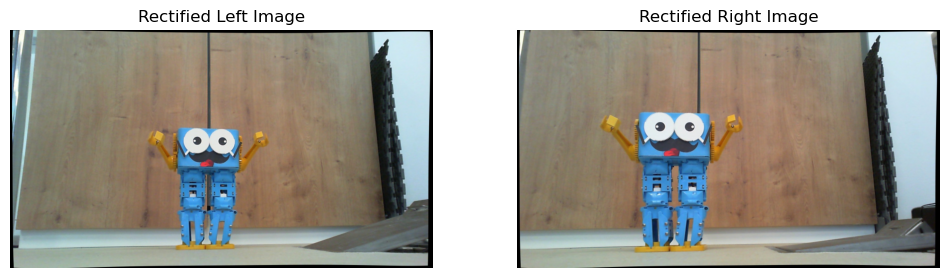

In [9]:
# Load calibration data from your report
camera_matrix = np.array([[1.13364493e+03, 0.0, 6.60786482e+02],
                         [0.0, 1.12446461e+03, 3.77012233e+02],
                         [0.0, 0.0, 1.0]])
distortion_coeffs = np.array([0.13847323, -0.92435038, 
                             0.00498605, 0.00659831, 1.34419323])

# Load images (replace paths)
img_left = cv2.imread("left2.jpg")
img_right = cv2.imread("right2.jpg")

# Check image loading
if img_left is None or img_right is None:
    raise FileNotFoundError("Images not found! Check file paths.")

# Undistort images
img_left_undistorted = cv2.undistort(img_left, camera_matrix, distortion_coeffs)
img_right_undistorted = cv2.undistort(img_right, camera_matrix, distortion_coeffs)

# Define extrinsics (adjust T based on your camera movement)
R = np.eye(3)  # Identity matrix (no rotation)
T = np.array([[-0.1], [0.0], [0.0]])  # Baseline: 0.1 units along x-axis

# Stereo rectification
rectify_scale = 1.0  # Full image area
(R1, R2, P1, P2, Q, roi1, roi2) = cv2.stereoRectify(
    cameraMatrix1=camera_matrix, distCoeffs1=distortion_coeffs,
    cameraMatrix2=camera_matrix, distCoeffs2=distortion_coeffs,
    imageSize=img_left.shape[:2][::-1], R=R, T=T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=rectify_scale)

# Compute rectification maps
map_left_x, map_left_y = cv2.initUndistortRectifyMap(
    camera_matrix, distortion_coeffs, R1, P1, 
    img_left.shape[:2][::-1], cv2.CV_32FC1)
map_right_x, map_right_y = cv2.initUndistortRectifyMap(
    camera_matrix, distortion_coeffs, R2, P2, 
    img_right.shape[:2][::-1], cv2.CV_32FC1)

# Apply rectification
img_left_rectified = cv2.remap(img_left_undistorted, map_left_x, map_left_y, cv2.INTER_LINEAR)
img_right_rectified = cv2.remap(img_right_undistorted, map_right_x, map_right_y, cv2.INTER_LINEAR)

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image"), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image"), plt.axis('off')
plt.show()

Total keypoints (left + right): 2023
Total matches: 399
Good matches (distance < 255.52): 313
Bad matches (distance >= 255.52): 86


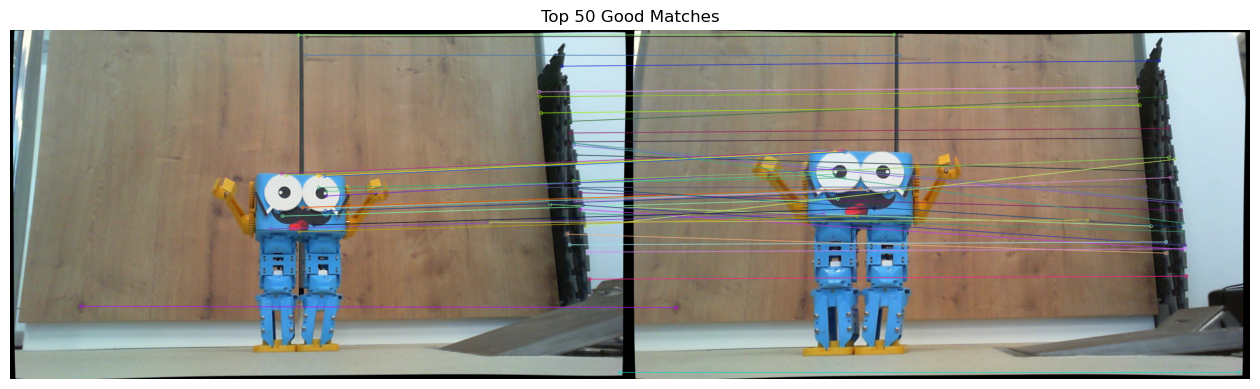

In [10]:
# ========== SIFT Detection ==========
sift = cv2.SIFT_create()

gray_left = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2GRAY)

kp_left, desc_left = sift.detectAndCompute(gray_left, None)
kp_right, desc_right = sift.detectAndCompute(gray_right, None)

# ========== BFMatcher ==========
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc_left, desc_right)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# ========== Count Features ==========
total_features_left = len(kp_left)
total_features_right = len(kp_right)
total_features = total_features_left + total_features_right

# ========== Basic "Good vs Bad" Classification ==========
#
# We'll define "good" matches as those whose distance is below
# some fraction of the maximum distance among all matches.
# Adjust this fraction as you see fit (e.g., 0.7, 0.8, etc.).
max_dist = matches[-1].distance  # distance of the worst match
distance_threshold = 0.7 * max_dist

good_matches = [m for m in matches if m.distance < distance_threshold]
bad_matches = [m for m in matches if m.distance >= distance_threshold]

num_good_matches = len(good_matches)
num_bad_matches = len(bad_matches)
total_matches = len(matches)

print(f"Total keypoints (left + right): {total_features}")
print(f"Total matches: {total_matches}")
print(f"Good matches (distance < {distance_threshold:.2f}): {num_good_matches}")
print(f"Bad matches (distance >= {distance_threshold:.2f}): {num_bad_matches}")

# ========== Visualize the Top N Good Matches ==========
N_MATCHES_TO_DISPLAY = 50
matched_image = cv2.drawMatches(
    img_left_rectified, kp_left,
    img_right_rectified, kp_right,
    good_matches[:N_MATCHES_TO_DISPLAY],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N_MATCHES_TO_DISPLAY} Good Matches")
plt.axis("off")
plt.show()

In [11]:
# 4) Extract Matched Points
# ----------------------------------------------------------------------------
# We need the (x,y) coordinates in each image to compute the Essential Matrix
pts_left = []
pts_right = []

for m in matches:
    # queryIdx = index of the descriptor in desc_left
    # trainIdx = index of the descriptor in desc_right
    pts_left.append(kp_left[m.queryIdx].pt)
    pts_right.append(kp_right[m.trainIdx].pt)

# Convert to NumPy arrays of shape (N,1,2) for OpenCV
pts_left = np.array(pts_left, dtype=np.float64).reshape(-1, 1, 2)
pts_right = np.array(pts_right, dtype=np.float64).reshape(-1, 1, 2)

# ----------------------------------------------------------------------------
# 5) Compute the Essential Matrix
# ----------------------------------------------------------------------------
# We assume the same camera matrix for both images.
# RANSAC helps filter outliers. Adjust threshold as needed.
E, mask = cv2.findEssentialMat(
    pts_left,
    pts_right,
    camera_matrix,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)

# 'mask' indicates inliers (1) vs. outliers (0)
inlier_count = np.count_nonzero(mask)
total_count = mask.size
print(f"Estimated Essential Matrix:\n{E}\n")
print(f"Inliers: {inlier_count}/{total_count} ({100*inlier_count/total_count:.2f}%)")

# ----------------------------------------------------------------------------
# 6) Recover Relative Pose (Rotation R, Translation t)
# ----------------------------------------------------------------------------
# recoverPose decomposes E into R and t
# Note: The translation is determined up to an unknown scale factor.
_, R_est, t_est, mask_pose = cv2.recoverPose(E, pts_left, pts_right, camera_matrix, mask=mask)

print("Recovered Pose:")
print("Rotation matrix (R):\n", R_est)
print("Translation vector (t):\n", t_est, "\n(Note: 't' is up to scale)")

inlier_count_pose = np.count_nonzero(mask_pose)
print(f"recoverPose inliers: {inlier_count_pose}/{total_count} ({100*inlier_count_pose/total_count:.2f}%)")

# ----------------------------------------------------------------------------
# 7) Evaluate Accuracy (If Ground Truth is Known)
# ----------------------------------------------------------------------------
# Suppose you have a known (true) rotation R_gt and translation t_gt
# from your stereo rig or from a synthetic setup. You must define them:
# e.g., R_gt = np.eye(3, dtype=np.float64)
#       t_gt = np.array([[1.0], [0.0], [0.0]], dtype=np.float64)

# -- Replace these with your actual known R and t
# For demonstration, let's assume some "dummy" ground truth:
R_gt = np.eye(3, dtype=np.float64)
t_gt = np.array([[1.0], [0.0], [0.0]], dtype=np.float64)

# We'll define two helper functions: 
#   1) rotation_error_deg(...) - compute rotation difference in degrees
#   2) translation_error_deg(...) - compute angle between the translation vectors

def rotation_error_deg(R1, R2):
    """
    Compute the rotational error (in degrees) between two 3x3 rotation matrices.
    We use:  angle = arccos((trace(R1^T * R2) - 1) / 2)
    """
    # Ensure they're valid rotation matrices
    # For numerical stability, we clamp the value inside arccos to [-1, 1]
    R_diff = R1.T @ R2  # R_diff should be identity if they're the same
    trace_val = np.trace(R_diff)
    # Because of float rounding, clip the value into the valid range for arccos
    cos_angle = (trace_val - 1.0) / 2.0
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_rad = np.arccos(cos_angle)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def translation_error_deg(t1, t2):
    """
    Compute the angle (in degrees) between two translation vectors (ignoring scale).
    angle = arccos( (t1·t2) / (||t1|| * ||t2||) )
    """
    # Normalize vectors
    t1_norm = t1 / (np.linalg.norm(t1) + 1e-15)
    t2_norm = t2 / (np.linalg.norm(t2) + 1e-15)
    dot = np.clip(np.dot(t1_norm.ravel(), t2_norm.ravel()), -1.0, 1.0)
    angle_rad = np.arccos(dot)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Compute rotation error
rot_err = rotation_error_deg(R_gt, R_est)

# Compute translation direction error
trans_err = translation_error_deg(t_gt, t_est)

print("\n===== Accuracy Evaluation =====")
print(f"Rotation error vs. ground truth:  {rot_err:.4f} degrees")
print(f"Translation direction error vs. ground truth: {trans_err:.4f} degrees")

# If you know the scale (e.g., the true baseline distance),
# you can also evaluate the magnitude error. For instance:
true_baseline = 1.0  # Suppose you know the baseline is 1.0 units
est_baseline = np.linalg.norm(t_est)
baseline_err = abs(est_baseline - true_baseline)
print(f"Baseline magnitude error: {baseline_err:.4f} (estimated: {est_baseline:.4f}, true: {true_baseline:.4f})")

Estimated Essential Matrix:
[[ 1.33743633e-02 -6.44579127e-01  9.39991763e-02]
 [ 6.36067680e-01  6.79592632e-03 -2.96488270e-01]
 [-9.07998396e-02  2.73358265e-01 -3.24902736e-04]]

Inliers: 127/399 (31.83%)
Recovered Pose:
Rotation matrix (R):
 [[ 0.9993007   0.01579188 -0.03389281]
 [-0.01620134  0.99979864 -0.01184057]
 [ 0.033699    0.0123814   0.99935533]]
Translation vector (t):
 [[-0.38859498]
 [-0.12220006]
 [-0.91326945]] 
(Note: 't' is up to scale)
recoverPose inliers: 92/399 (23.06%)

===== Accuracy Evaluation =====
Rotation error vs. ground truth:  2.2525 degrees
Translation direction error vs. ground truth: 112.8671 degrees
Baseline magnitude error: 0.0000 (estimated: 1.0000, true: 1.0000)


In [12]:

# Filter points to inliers only (for better triangulation)
pts_left_in = pts_left[mask_pose.ravel() == 1]
pts_right_in = pts_right[mask_pose.ravel() == 1]

# ----------------------------------------------------------------------------
# 6. Triangulate Points
# ----------------------------------------------------------------------------
# Construct projection matrices for the two views:
#   P1 = K [I | 0]
#   P2 = K [R | t]
# We'll assume the first camera at origin, second at (R_est, t_est).
# The shape of P1/P2 must be 3x4.
P1 = camera_matrix @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = camera_matrix @ np.hstack((R_est, t_est))

# pts_left_in, pts_right_in must be shape (N, 2) for cv2.triangulatePoints to accept them (as transposed float32 arrays).
pts_left_in_2d  = pts_left_in.reshape(-1, 2).T
pts_right_in_2d = pts_right_in.reshape(-1, 2).T

# OpenCV expects float32
pts_left_in_2d  = pts_left_in_2d.astype(np.float32)
pts_right_in_2d = pts_right_in_2d.astype(np.float32)

# Triangulate
points_4d_hom = cv2.triangulatePoints(P1, P2, pts_left_in_2d, pts_right_in_2d)
# Convert from homogeneous to 3D
points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]  # shape (3, N)

print(f"[Triangulation] Triangulated {points_3d.shape[1]} points.")

# ----------------------------------------------------------------------------
# 7. Basic 3D Visualization (Optional)
# ----------------------------------------------------------------------------
# We'll plot the 3D points in matplotlib. 
# (For large point sets, you may want a more efficient viewer or Open3D.)
x_vals = points_3d[0, :]
y_vals = points_3d[1, :]
z_vals = points_3d[2, :]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals, s=1, c='b', marker='.')
ax.set_title("Sparse 3D Reconstruction")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.show()

# ----------------------------------------------------------------------------
# 8. Evaluate Accuracy (Optional)
# ----------------------------------------------------------------------------
# (A) Reprojection Error:
#     We can project the 3D points back to each camera and measure distance to the original 2D keypoints.
def reprojection_error(P, pts_3d, pts_2d):
    """
    P: 3x4 projection matrix
    pts_3d: 3xN
    pts_2d: Nx2
    Returns average reprojection error in pixels.
    """
    # Convert to homogeneous
    N = pts_3d.shape[1]
    homog_3d = np.vstack((pts_3d, np.ones((1, N))))
    projected = P @ homog_3d  # shape (3, N)
    # Convert back to inhom (x/z, y/z)
    projected_inhom = projected[:2, :] / projected[2, :]
    # Compute error
    diff = projected_inhom.T - pts_2d  # shape (N, 2)
    error = np.sqrt((diff**2).sum(axis=1))  # per-point
    return np.mean(error)

# We'll check reprojection to both cameras
pts_2d_left_in  = pts_left_in.reshape(-1,2)
pts_2d_right_in = pts_right_in.reshape(-1,2)

err_left  = reprojection_error(P1, points_3d, pts_2d_left_in)
err_right = reprojection_error(P2, points_3d, pts_2d_right_in)

print(f"[Reprojection Error]")
print(f" Left image avg error:  {err_left:.4f} pixels")
print(f" Right image avg error: {err_right:.4f} pixels")

# (B) If you have ground-truth 3D or known scene geometry, 
#     you can compare the triangulated points to those as well.

[Triangulation] Triangulated 92 points.


[Reprojection Error]
 Left image avg error:  0.2797 pixels
 Right image avg error: 0.3214 pixels


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d  # <--- For 3D visualization

# ----------------------------------------------------------------------------
# 1) Filter Inliers, Construct Projection Matrices
# ----------------------------------------------------------------------------
# Filter points to inliers only (for better triangulation)
pts_left_in = pts_left[mask_pose.ravel() == 1]
pts_right_in = pts_right[mask_pose.ravel() == 1]

# Construct projection matrices for the two views:
#   P1 = K [I | 0]
#   P2 = K [R | t]
P1 = camera_matrix @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = camera_matrix @ np.hstack((R_est, t_est))

# Prepare points for cv2.triangulatePoints (N,2) --> transpose --> (2,N)
pts_left_in_2d  = pts_left_in.reshape(-1, 2).T.astype(np.float32)
pts_right_in_2d = pts_right_in.reshape(-1, 2).T.astype(np.float32)

# ----------------------------------------------------------------------------
# 2) Triangulate 3D Points
# ----------------------------------------------------------------------------
points_4d_hom = cv2.triangulatePoints(P1, P2, pts_left_in_2d, pts_right_in_2d)
points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]  # shape = (3, N)
print(f"[Triangulation] Triangulated {points_3d.shape[1]} points.")

# ----------------------------------------------------------------------------
# 3) 3D Visualization in a Separate Window (Open3D)
# ----------------------------------------------------------------------------
# Convert points_3d (3,N) to (N,3)
points_3d_np = points_3d.T  # shape = (N, 3)

# Create an Open3D PointCloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d_np)

# Launch an interactive Open3D viewer with no Matplotlib axes
# (You can rotate, zoom, and pan in 3D.)
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="3D Reconstruction", width=800, height=600)
vis.add_geometry(pcd)

# Optionally hide the origin coordinate frame:
opt = vis.get_render_option()
opt.show_coordinate_frame = False

vis.run()
vis.destroy_window()

# ----------------------------------------------------------------------------
# 4) Evaluate Accuracy (Optional)
# ----------------------------------------------------------------------------
# (A) Reprojection Error:
def reprojection_error(P, pts_3d, pts_2d):
    """
    P: 3x4 projection matrix
    pts_3d: 3xN
    pts_2d: Nx2
    Returns average reprojection error in pixels.
    """
    N = pts_3d.shape[1]
    homog_3d = np.vstack((pts_3d, np.ones((1, N))))  # shape = (4, N)
    projected = P @ homog_3d  # shape = (3, N)
    projected_inhom = projected[:2, :] / projected[2, :]
    diff = projected_inhom.T - pts_2d  # shape = (N, 2)
    error = np.sqrt((diff**2).sum(axis=1))  # per-point Euclidean error
    return np.mean(error)

pts_2d_left_in  = pts_left_in.reshape(-1,2)
pts_2d_right_in = pts_right_in.reshape(-1,2)

err_left  = reprojection_error(P1, points_3d, pts_2d_left_in)
err_right = reprojection_error(P2, points_3d, pts_2d_right_in)

print(f"\n[Reprojection Error]")
print(f" Left image avg error:  {err_left:.4f} pixels")
print(f" Right image avg error: {err_right:.4f} pixels")

# (B) If you have ground-truth 3D or known scene geometry,
#     you can compare the triangulated points to those as well.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Triangulation] Triangulated 92 points.

[Reprojection Error]
 Left image avg error:  0.2797 pixels
 Right image avg error: 0.3214 pixels
